In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math
from tqdm.notebook import tqdm
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from einops import rearrange, reduce, repeat

In [13]:
import parser
import transformer
import longrange
import dataset
import train

In [4]:
ids_book = parser.book2ids()

In [5]:
ds_train, ds_test = dataset.create_dataset(tqdm=tqdm)

  0%|          | 0/3037 [00:00<?, ?it/s]

  0%|          | 0/2428 [00:00<?, ?it/s]

torch.Size([948753124])


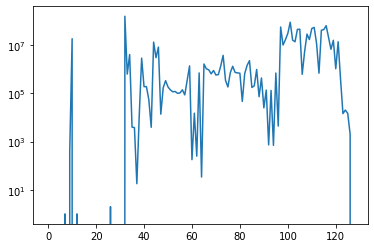

In [110]:
ids_all = torch.cat([ids for book, ids in tqdm(ds_train.items())])
print(ids_all.shape)
count = ids_all.bincount(minlength=128)
plt.plot(count)
plt.yscale('log')

In [118]:
len(ds_test)

607

In [18]:
for a, b in dataset.get_random_skip_batches(ds_train, 10, 32, 128, 0, 1):
    print(a.shape, b.shape)
    print(parser.ids2text(a[0]) +'|'+ parser.ids2text(b[0]))
    print('\n\n')

torch.Size([32, 128]) torch.Size([32, 128])
ox or two, and a few
sheep; not much, my lords, but still a little food."

"It is good," said I. "Infadoos; we are weary with tr|avelling through
realms of air; now let us rest."

Accordingly we entered the hut, which we found amply prepared for our
comfort



torch.Size([32, 128]) torch.Size([32, 128])
he added, turning towards the door, "we have barely a quarter of an
hour to get to the Carlton. I dare not be late. The only per|son,"
she went on, as they passed through the outer office and Arnold
paused for a moment to take down his hat and coat, "whom I



torch.Size([32, 128]) torch.Size([32, 128])
 pendulous cheeks, and a
general air of superficial benevolence which was marred by a cruel,
vicious mouth.

"There is surely so|me mistake here, gentlemen," he said in an unctuous,
make-everything-easy voice.  "I fancy that you have been misdirected.
Possi



torch.Size([32, 128]) torch.Size([32, 128])
ast with the purple and gold.

The interi

In [63]:
config = transformer.get_config('gpt-nano', n_latent_tokens=None)
print(config)
net = transformer.GPT(config)
train.train_transformer(ds_train, net, n_batches=1000, batch_size=256, seq_len=30, device='cpu', tqdm=tqdm)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 3, 'n_head': 3, 'n_embd': 48, 'n_latent_tokens': None}


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [104]:
config = transformer.get_config('gpt-nano', n_latent_tokens=30)
# config = transformer.get_config('gpt-nano')
print(config)
net = transformer.GPT(config)


batch = torch.randint(0, 128, (32, 100))
net(batch);

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 3, 'n_head': 3, 'n_embd': 48, 'n_latent_tokens': 30}


torch.Size([32, 30, 100])


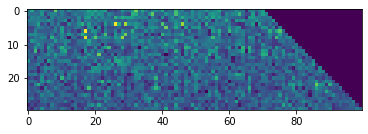

torch.Size([32, 30, 30])


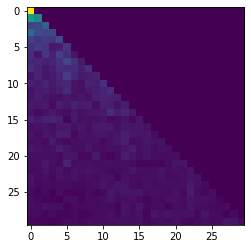

torch.Size([32, 30, 30])


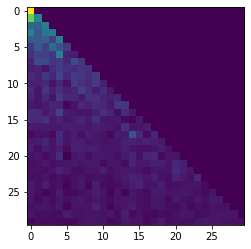

In [105]:
for block in net.blocks:
    print(block.attn_weights.shape)
    plt.imshow(block.attn_weights.detach().numpy()[0])
    plt.show()

In [107]:
config = transformer.get_config('gpt-nano')
net = longrange.LongRangeGPT(config)

batch = torch.randint(0, 128, (32, 100))
net(batch, long_range_input=torch.randn(32, 10, 48), calc_long_range_output=True);

torch.Size([32, 100, 100])


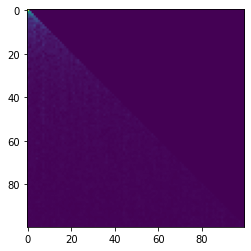

torch.Size([32, 100, 100])


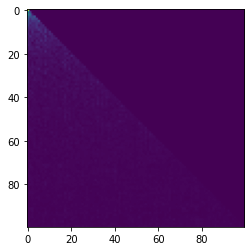

torch.Size([32, 100, 110])


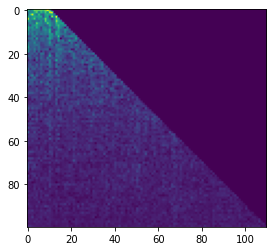

In [108]:
for block in net.blocks:
    print(block.attn_weights.shape)
    plt.imshow(block.attn_weights.detach().numpy()[0])
    plt.show()

In [109]:
train.train_longrange(ds_train, net, n_batches=1000, batch_size=32, seq_len=30, device='cpu', tqdm=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
net(ids_book[None, :100]).shape

torch.Size([1, 100, 128])

In [19]:
a = transformer.generate(net, ids_book[None, :100], 100)
parser.ids2text(a[0])

'Agatha Christie - Murder Of Roger Ackroyd \n\nBook Jacket \n\nNone \n\n\n\nAgatha Christie - The Murder Of R.\x05NpKz\x15\x05N43kd\x1f\x153k"z\x15\tZ\x1fPz\x153(3(Pz\x7f\x058Pz\x1d\x153k"Wd\x1f\x15\x05NW\x178Pk_37.\x05NpKz\x15\t~38zppR.\x05.\x05NpKz\x1d\x1d*9U#\x1d*\x05.\x05.\x05.\x05.*9]\x06"'

In [8]:
# config = transformer.get_config('gpt-nano', n_latent_tokens=30)
config = transformer.get_config('gpt-nano')
print(config)
net = longrange.LongRangeGPT(config)

{'n_vocab': 128, 'max_context_length': None, 'embd_pdrop': 0.1, 'resid_pdrop': 0.1, 'attn_pdrop': 0.1, 'n_layer': 3, 'n_head': 3, 'n_embd': 48, 'n_latent_tokens': None}


In [9]:
logits1, lro1 = net.forward(ids_book[None, :100], calc_long_range_output=True)
logits2, lro2 = net.forward(ids_book[None, 200:300], long_range_input=lro1)
logits1.shape, logits2.shape, lro1.shape, lro2

(torch.Size([1, 100, 128]),
 torch.Size([1, 100, 128]),
 torch.Size([1, 100, 48]),
 None)

In [ ]:
config = transformer.get_config('gpt-nano')
print(config)
net = longrange.LongRangeGPT(config)
train_longrange(net, ds_train, 1000)

In [36]:
batch = next(dataset.get_random_batches(ds_train, 1, 1, 100))
print(parser.ids2text(batch))
print()
batch0, batch1 = next(dataset.get_random_skip_batches(ds_train, 1, 1, 100, 100, 200))

print(parser.ids2text(batch0))
print(parser.ids2text(batch1))

['\n\nHe pointed to a pub up a side street, and went in with Kumbo holding on\nto his arm.  The barman wa']

['t."\n\nLame Katy felt as if "a truly angel" was embracing her, and could only\nstammer out her thanks, ']
['their gifts for her to see and admire.\n\nMamma leaned down and whispered one word to the older girls;']
